In [1]:
import pandas as pd
import numpy as np
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Stock Return Correlation Prediction

## In sample analysis
## Panel regression

In [2]:
# load data
file_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/data/Data/tbn_cor_panel.csv'
correlation_df = pd.read_csv(file_path)

In [3]:
# index and NULL
correlation_df = correlation_df.dropna()
correlation_df = correlation_df.set_index(["year", "gvkey12"])
#correlation_df = correlation_df.set_index(["gvkey12", "year"])

In [9]:
# new dummines
correlation_df['interaction'] = correlation_df['rho_lag'] * correlation_df['score_lag'] 

In [16]:
# linear regression
exog_vars = ["rho_lag", "score_lag", 'multiplier']
exog = sm.add_constant(correlation_df[exog_vars])
mod = PooledOLS(correlation_df.rho, exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    rho   R-squared:                        0.4037
Estimator:                  PooledOLS   R-squared (Between):              0.8474
No. Observations:               94377   R-squared (Within):               0.2580
Date:                Wed, Nov 17 2021   R-squared (Overall):              0.4037
Time:                        00:38:05   Log-likelihood                 5.108e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   6.391e+04
Entities:                        4692   P-value                           0.0000
Avg Obs:                       20.114   Distribution:                 F(1,94375)
Min Obs:                       3.0000                                           
Max Obs:                       21.000   F-statistic (robust):          6.391e+04
                            

In [35]:
beta = pooled_res.params
p_values = pooled_res.pvalues
R_2 = pooled_res.rsquared
F_test = pooled_res.f_statistic
observation = pooled_res.nobs

## Out of sample prediction

### Data split
The first 5 years data are used to train the model and the next year data are use to test the model

In [6]:
# rolling window subset (idx)
window_size = 5
year_range = np.unique(correlation_df.index.get_level_values(0))
year_start = year_range[0]
year_end = year_range[-1]
train_idx_list = [np.arange(year, year + window_size, 1) for year in year_range[:-window_size]]
test_idx_list = [subset[-1] + 1 for subset in train_idx_list]

In [11]:
# test the first subset
df_train = correlation_df.loc[train_idx_list[0]]
df_test = correlation_df.loc[test_idx_list[0]]

### Feture selection
skip at first

In [24]:
feature = ['rho_lag', 'score_lag']
dep_var = 'rho'
X_train = df_train[feature]
X_test = df_test[feature]
y_train = df_train[dep_var]
y_test = df_test[dep_var]

### Model tunning

In [49]:
from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# set the range of parameters to be tuned
param_grid = {"epsilon": [0.1, 0.01], "C": [1, 10, 100, 1000], 'gamma': [0.1, 0.001, 0.00001]}

# grid search using cross validation
grid = GridSearchCV(SVR(kernel = 'rbf'),
                    cv = 3,
                    param_grid = param_grid, 
                    scoring = scorer, 
                    refit=True,
                    verbose=2,
                    n_jobs=-1) 

grid_fit = grid.fit(X_train, y_train)

print(grid_fit.best_params_)
print(grid_fit.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'C': 1000, 'epsilon': 0.1, 'gamma': 0.1}
-0.015684774235615005


### Model build

In [50]:
regressor = SVR(kernel = 'rbf', C = 1000, gamma=0.1)
regressor.fit(X_train, y_train)

SVR(C=1000, gamma=0.1)

In [27]:
regressor_linear = LinearRegression()
regressor_linear.fit(X_train, y_train)

LinearRegression()

### Model evaluation

In [51]:
y_predict = regressor.predict(X_test)
mean_squared_error(y_predict, y_test)

0.03774174748240042

In [28]:
y_predict = regressor_linear.predict(X_test)
mean_squared_error(y_predict, y_test)

0.037605678880289296

### Rolling window prediction

In [40]:
feature = ['score_lag','interaction']

In [41]:
loss_list = []
loss_list_benchmark = []

for train_idx, test_idx in zip(train_idx_list, test_idx_list):
    # construct data subset
    df_train = correlation_df.loc[train_idx]
    df_test = correlation_df.loc[test_idx]
    X_train = df_train[feature]
    X_test = df_test[feature]
    y_train = df_train[dep_var]
    y_test = df_test[dep_var]

    # model build
    regressor = SVR(kernel = 'rbf',C = 1000, gamma=0.1)
    regressor_linear = LinearRegression()
    regressor.fit(X_train, y_train)
    regressor_linear.fit(X_train, y_train)

    # model evaluation
    y_predict = regressor.predict(X_test)
    model_loss = mean_squared_error(y_predict, y_test)
    loss_list.append(model_loss)

    y_predict = regressor_linear.predict(X_test)
    model_loss = mean_squared_error(y_predict, y_test)
    loss_list_benchmark.append(model_loss)


In [42]:
loss_df = pd.DataFrame([loss_list, loss_list_benchmark]).T
loss_df.columns = ['SVR', 'Linear']
loss_df.index = test_idx_list

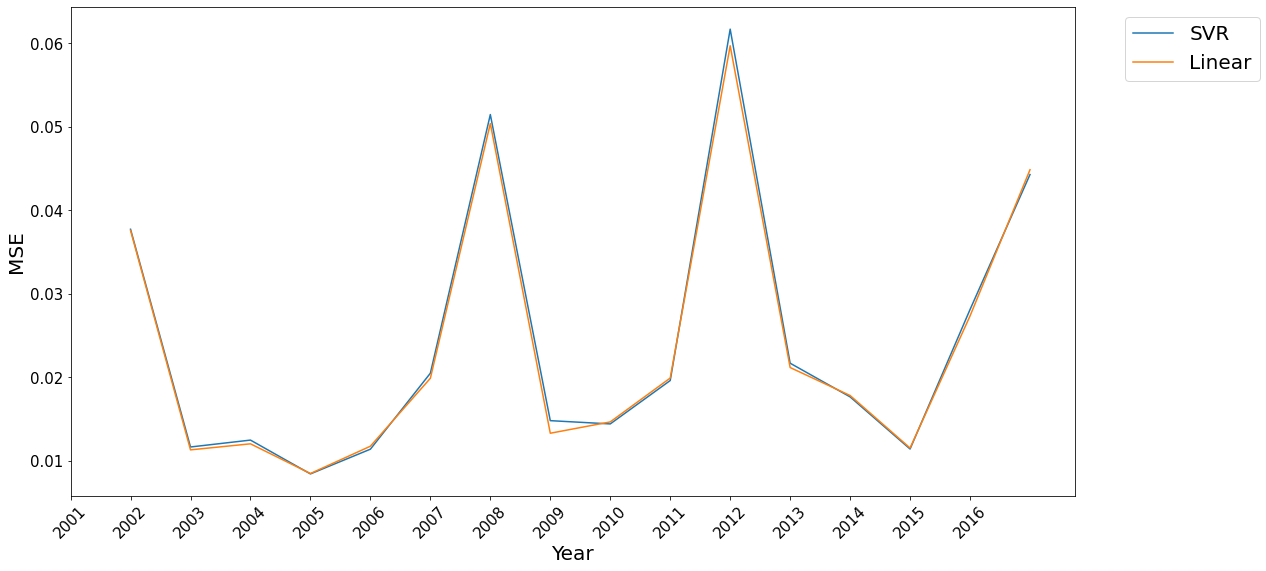

In [34]:
plot = loss_df.plot(title = None,
                    xlabel = 'Year',
                    ylabel = 'MSE',
                    figsize = (18, 9),
                    fontsize = 15,
                    xticks = range(2001, 2017),
                    rot = 45)

plot.axes.xaxis.label.set_size(20)
plot.axes.yaxis.label.set_size(20)
plot.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 20})

In [29]:
output_path = '/Users/cheng/Dropbox/Apps/Overleaf/Weekly Report Cheng/figure/'
file_name = 'Stock return correlation prediction with SVR (without interaction)'
file_type = '.png'
plot.figure.tight_layout()
plot.figure.savefig(output_path + file_name + file_type)

### Feature sensitivity

In [51]:
loss_df_linear = pd.concat([loss_df_without_rho['Linear'], loss_df_without_score['Linear'], loss_df_without_interaction['Linear'], loss_df_full['Linear']], axis=1)
loss_df_linear.columns = ['model without rho', 'model without score', 'model without interaction', 'model with all']

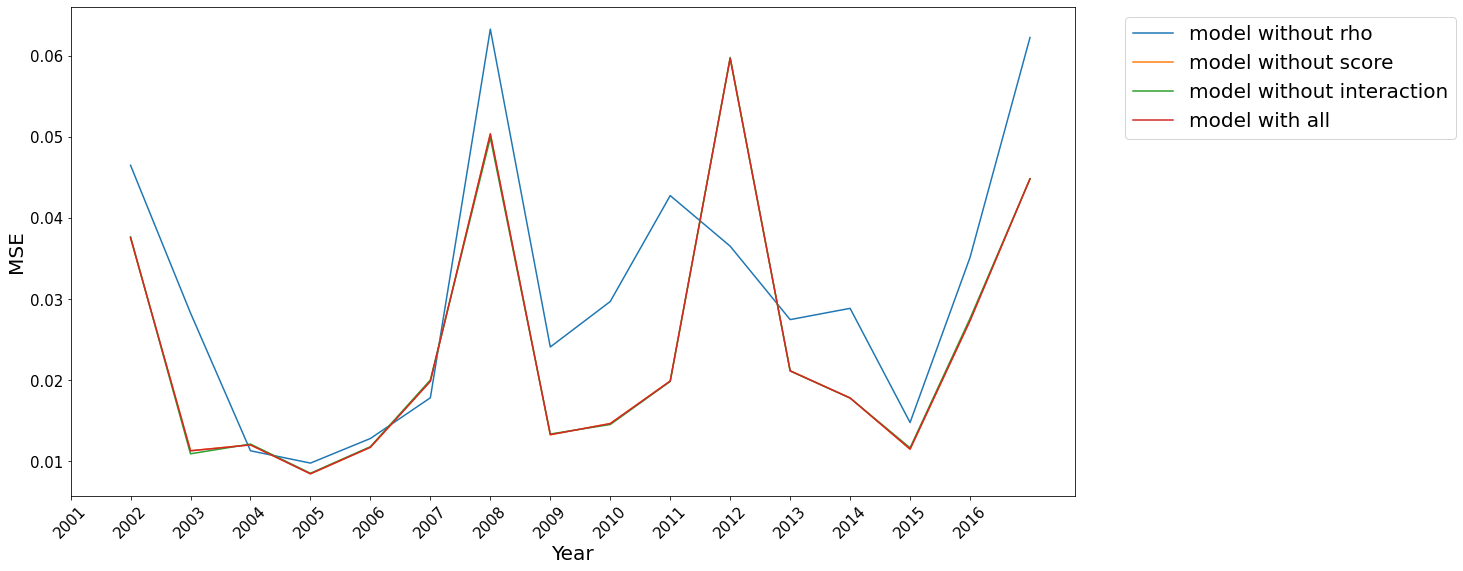

In [53]:
plot = loss_df_linear.plot(title = None,
                    xlabel = 'Year',
                    ylabel = 'MSE',
                    figsize = (18, 9),
                    fontsize = 15,
                    xticks = range(2001, 2017),
                    rot = 45)

plot.axes.xaxis.label.set_size(20)
plot.axes.yaxis.label.set_size(20)
plot.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 20})

In [54]:
output_path = '/Users/cheng/Dropbox/Apps/Overleaf/Weekly Report Cheng/figure/'
file_name = 'Stock return correlation prediction with linear regression'
file_type = '.png'
plot.figure.tight_layout()
plot.figure.savefig(output_path + file_name + file_type)

In [55]:
loss_df_svr = pd.concat([loss_df_without_rho['SVR'], loss_df_without_score['SVR'], loss_df_without_interaction['SVR'], loss_df_full['SVR']], axis=1)
loss_df_svr.columns = ['model without rho', 'model without score', 'model without interaction', 'model with all']

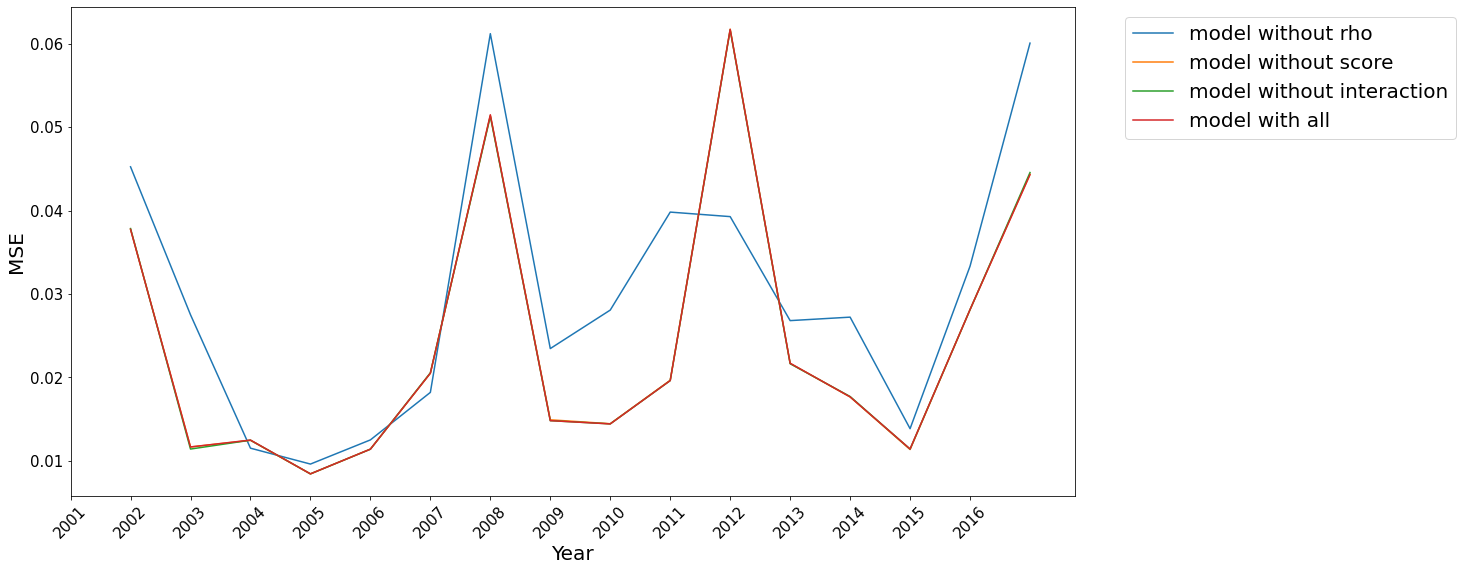

In [60]:
plot = loss_df_svr.plot(title = None,
                    xlabel = 'Year',
                    ylabel = 'MSE',
                    figsize = (18, 9),
                    fontsize = 15,
                    xticks = range(2001, 2017),
                    rot = 45)

plot.axes.xaxis.label.set_size(20)
plot.axes.yaxis.label.set_size(20)
plot.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 20})

In [59]:
output_path = '/Users/cheng/Dropbox/Apps/Overleaf/Weekly Report Cheng/'
file_name = 'Stock return correlation prediction with SVR'
file_type = '.png'
plot.figure.tight_layout()
plot.figure.savefig(output_path + file_name + file_type)